In [1]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F

import scipy.linalg
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

with open('/home/adam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_09022022.pickle', 'rb') as file:
    full_dict = pickle.load(file)
    train_X, train_y, train_mask, train_radii, train_ids = full_dict['train_dict']['padded']['profiles'],full_dict['train_dict']['padded']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['padded']['radii'] , full_dict['train_dict']['padded']['pulse_time_ids'] 
    val_X, val_y, val_mask, val_radii, val_ids = full_dict['val_dict']['padded']['profiles'],full_dict['val_dict']['padded']['controls'], full_dict['val_dict']['padded']['masks'], full_dict['val_dict']['padded']['radii'], full_dict['val_dict']['padded']['pulse_time_ids']
    test_X, test_y, test_mask, test_radii, test_ids = full_dict['test_dict']['padded']['profiles'],full_dict['test_dict']['padded']['controls'], full_dict['test_dict']['padded']['masks'], full_dict['test_dict']['padded']['radii'], full_dict['test_dict']['padded']['pulse_time_ids']

In [2]:
from moxie.models.DIVA_ak_1 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK

import pytorch_lightning as pl 
model_hyperparams = {'in_ch': 2, 'out_length':19,
    'mach_latent_dim': 11, 'stoch_latent_dim': 3,
    'beta_stoch': 100e-3,
    'beta_mach':  100., 'alpha_mach': 1.0, 'alpha_prof': 1.0,
    'loss_type': 'semi-supervised'}
model = DIVAMODEL(**model_hyperparams)

state_dict = torch.load('./model_results/modelstatedict_SECULAR_11MD_3SD_100BM_1AM_1AP.pth')
model.load_state_dict(state_dict['model'])



<All keys matched successfully>

In [3]:
# Helper Functions
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var


def get_latent_space(in_profiles, model): 
    with torch.no_grad(): 
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(in_profiles)
        z_stoch, z_mach = model.reparameterize(mu_stoch, log_var_stoch), model.reparameterize(mu_mach, log_var_mach)
        z = torch.cat((z_stoch, z_mach), 1)
    return z_mach, z_stoch, z

def get_mps(z_mach, model):
    with torch.no_grad(): 
        out_mp = model.q_hatxzmach(z_mach)
    out_mp_real = de_standardize(out_mp, MP_norm, MP_var)
    return out_mp, out_mp_real

def get_latent_space_from_cond(in_mps, model):
    with torch.no_grad(): 
        c_mu, c_var = model.p_zmachx(in_mps)
        z_mach = model.reparameterize(c_mu, c_var)
    return z_mach

LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']

# Things that don't change after training 
MP_norm, MP_var = state_dict['MP_norms']
norms_MP = MP_norm, MP_var
D_norm, D_var = state_dict['D_norms']
norms_D = D_norm, D_var
T_norm, T_var = state_dict['T_norms']
norms_T = T_norm, T_var


# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()

# Convert q to q_cly


# Q_cyc= ((1+2kappa^2) / 2 ) * (2pia^2 Bt) / (R IP  mu_0)

train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
test_mp_tensors = torch.tensor(test_y).float()
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X)

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized[:, 0] = standardize(train_profiles_normalized[:, 0], D_norm, D_var)
train_profiles_normalized[:, 1] = standardize(train_profiles_normalized[:, 1], T_norm, T_var)


test_profiles = torch.tensor(test_X).float()

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized[:, 0] = standardize(test_profiles_normalized[:, 0], D_norm, D_var)
test_profiles_normalized[:, 1] = standardize(test_profiles_normalized[:, 1], T_norm, T_var)



Z_MACH_TRAINING, Z_STOCH_TRAINING, Z_TRAINING = get_latent_space(train_profiles_normalized, model)
PRED_MPS_FROM_Z_TRAINING_NORM, PRED_MPS_FROM_Z_TRAINING_REAL = get_mps(Z_MACH_TRAINING, model)

Z_MACH_TEST, Z_STOCH_TEST, Z_TEST = get_latent_space(test_profiles_normalized, model)
PRED_MPS_FROM_Z_TEST_NORM, PRED_MPS_FROM_Z_TEST_REAL = get_mps(Z_MACH_TEST, model)


FROM_COND_Z_MACH = get_latent_space_from_cond(train_mp_normalized, model)
FROM_COND_MPS_NORM, FROM_COND_MPS_REAL = get_mps(FROM_COND_Z_MACH, model)

In [8]:
FROM_COND_Z_MACH.shape
torch.distributions.normal.Normal(0,1).sample((FROM_COND_Z_MACH.shape[0], 3))

tensor([[-0.8196,  0.8320, -0.0794],
        [-0.3432, -0.5289, -0.7596],
        [-0.1972,  0.0341,  0.3640],
        ...,
        [ 0.8910, -0.0848,  0.4897],
        [ 1.9413, -0.3181,  0.4071],
        [-1.0428,  0.3212, -0.3365]])

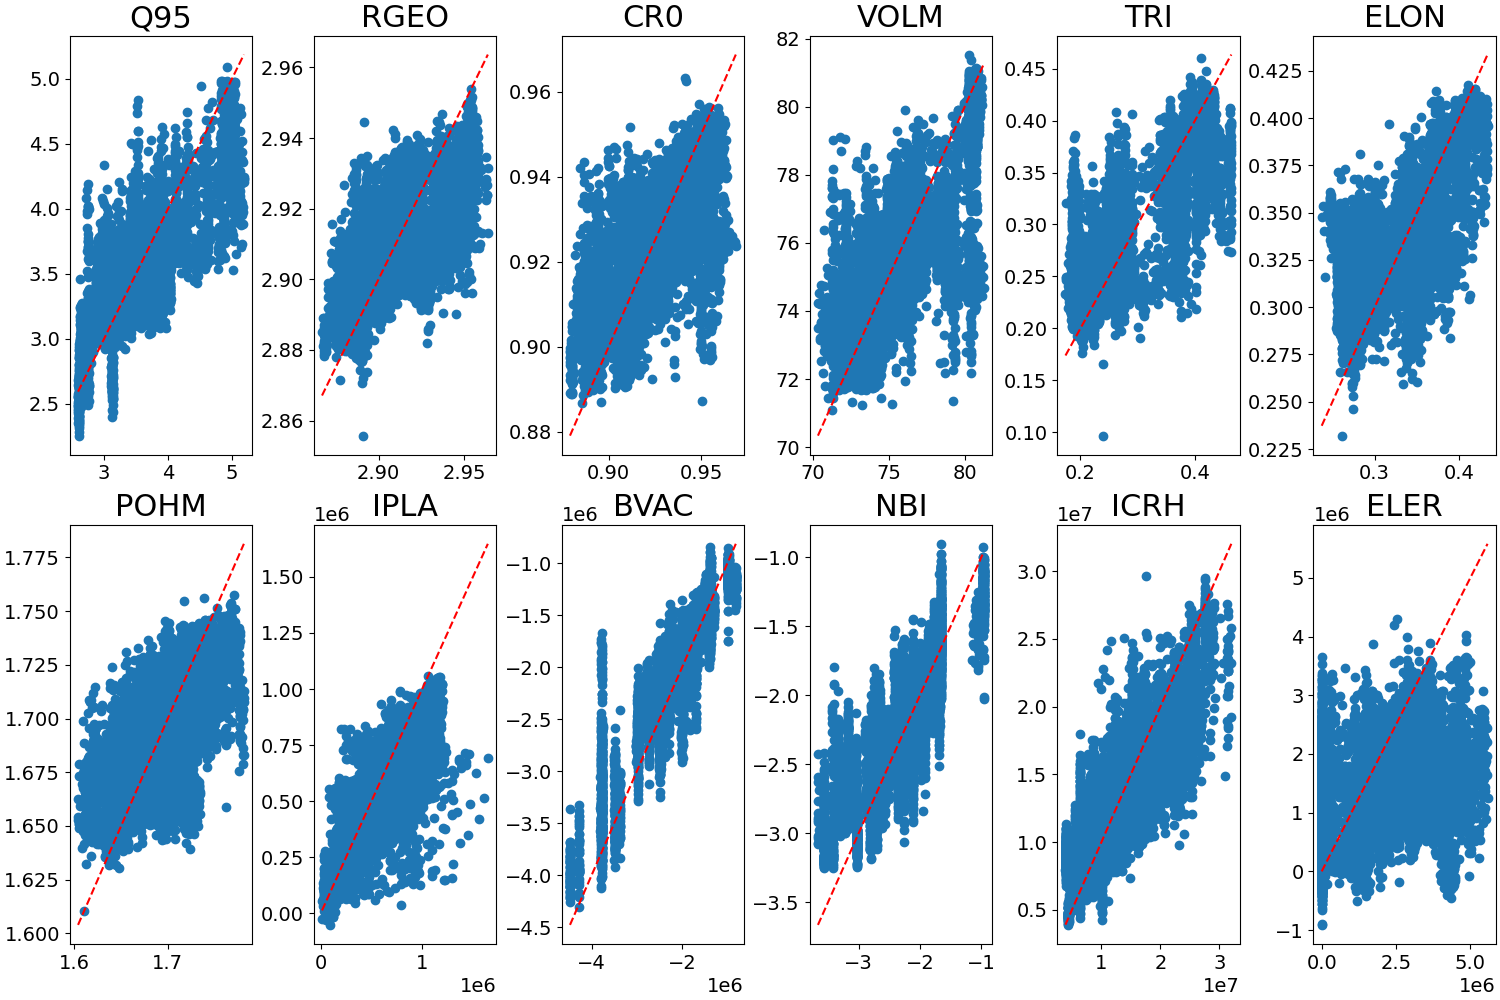

In [47]:
LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']

real_mps = test_mp_tensors # train_mp_tensors
predicted_mps = PRED_MPS_FROM_Z_TEST_REAL # PRED_MPS_FROM_Z_TRAINING_REAL
plt.close()

passed_tri = False
fig, axs = plt.subplots(2, 6, constrained_layout=True, figsize=(15, 10))

axs = axs.ravel()
for n, label in enumerate(LABEL): 
    i = n - passed_tri
    if label == 'TRIU': 
        i = 4
        axs[i].scatter((real_mps[:, 4] + real_mps[:, 5])/2.0, (predicted_mps[:, 4] + predicted_mps[:, 5])/2.0)
        axs[i].set_title('TRI')
        axs[i].plot([min((real_mps[:, 4] + real_mps[:, 5])/2.0), max((real_mps[:, 4] + real_mps[:, 5])/2.0)], [min((real_mps[:, 4] + real_mps[:, 5])/2.0), max((real_mps[:, 4] + real_mps[:, 5])/2.0)], ls='--', color='red')
        passed_tri = True
        continue
    elif label == 'TRIL': 
        continue
    axs[i].scatter(real_mps[:, i], predicted_mps[:, i])
    axs[i].plot([min(real_mps[:, i]), max(real_mps[:, i])], [min(real_mps[:, i]), max(real_mps[:, i])], ls='--', color='red')
    axs[i].set_title(label)
plt.show()



In [30]:
import seaborn as sns

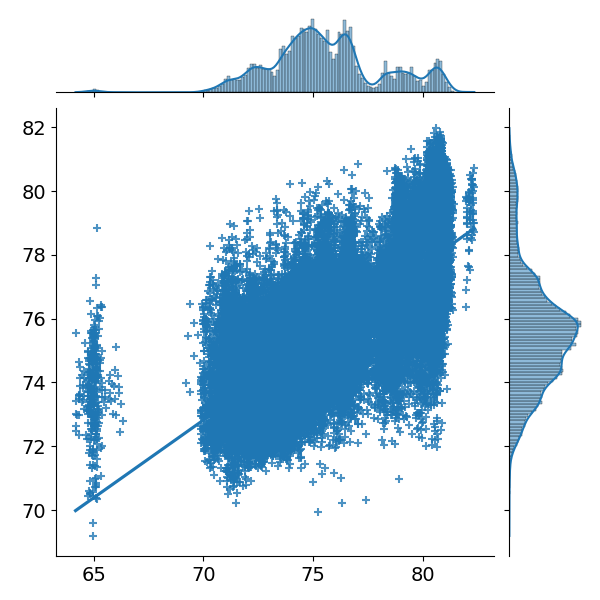

In [35]:
sns.jointplot(x=train_mp_tensors[:, 3], y=PRED_MPS_FROM_Z_TRAINING_REAL[:, 3], kind='reg', marker='+')

In [58]:
# LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
train_mp_tensors = torch.tensor(train_y).float()
mu_0 = 1.25663706e-6
# Convert q to q_cly


# Q_cyc= ((1+2kappa^2) / 2 ) * (2 pi a^2 Bt) / (R IP  mu_0)

In [59]:
q_cly = ((1 + 2*train_mp_tensors[:, 6]**2) / 2.0) * (2*train_mp_tensors[:, 9]*torch.pi*train_mp_tensors[:, 2]**2) / (train_mp_tensors[:, 1] * train_mp_tensors[:, 8] * mu_0)

In [64]:
# train_mp_tensors[:, 0:1]
train_mp_tensors[:, 0] = ((1 + 2*train_mp_tensors[:, 6]**2) / 2.0) * (2*train_mp_tensors[:, 9]*torch.pi*train_mp_tensors[:, 2]**2) / (train_mp_tensors[:, 1] * train_mp_tensors[:, 8] * mu_0)

In [66]:
train_mp_tensors

tensor([[5.3932e+00, 2.9208e+00, 9.1762e-01,  ..., 1.4096e+07, 1.9495e+06,
         2.8118e+22],
        [5.3883e+00, 2.9216e+00, 9.1719e-01,  ..., 1.4097e+07, 1.9489e+06,
         2.8068e+22],
        [5.3836e+00, 2.9223e+00, 9.1680e-01,  ..., 1.4097e+07, 1.9709e+06,
         2.8083e+22],
        ...,
        [4.9551e+00, 2.8751e+00, 9.4546e-01,  ..., 2.4009e+07, 3.2414e+06,
         3.1084e+22],
        [4.9690e+00, 2.8751e+00, 9.4478e-01,  ..., 2.3477e+07, 3.2530e+06,
         3.0343e+22],
        [4.9907e+00, 2.8752e+00, 9.4457e-01,  ..., 2.2942e+07, 3.2683e+06,
         2.9595e+22]])

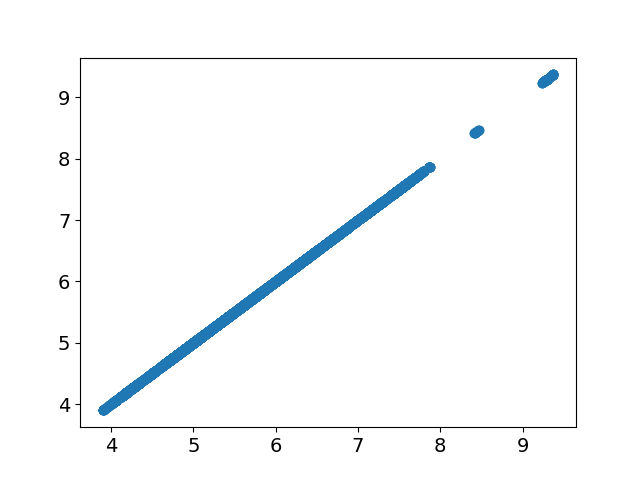

In [65]:
plt.close('all')

plt.scatter(q_cly, train_mp_tensors[:, 0])
plt.show()